In [1]:
!nvidia-smi

Fri Jul  5 09:19:23 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Install Dependencies
(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)

In [2]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5.git  # clone repo
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16725, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 16725 (delta 11), reused 32 (delta 7), pack-reused 16679
Receiving objects: 100% (16725/16725), 15.31 MiB | 16.19 MiB/s, done.
Resolving deltas: 100% (11490/11490), done.
/kaggle/working/yolov5


In [4]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
# from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 2.1.2 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16269MB, multi_processor_count=56)


In [5]:
# this is the YAML file  we're loading into this notebook with our data
%cat /kaggle/input/sign-language/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 7
names: ['Hello', 'I_Love_You', 'Namaste', 'No', 'Please', 'Thank_you', 'Yes']

roboflow:
  workspace: my-workspace-vtjjo
  project: sign-language-qpxsv
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/my-workspace-vtjjo/sign-language-qpxsv/dataset/1

In [6]:
!pwd

/kaggle/working/yolov5


In [7]:
# define number of classes based on YAML
import yaml
with open("/kaggle/input/sign-language/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

print(num_classes)

7


In [8]:
#this is the model configuration we will use
%cat /kaggle/working/yolov5/models/yolov5s.yaml

# Ultralytics YOLOv5 🚀, AGPL-3.0 license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4],

In [9]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [10]:
%%writetemplate /kaggle/working/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [11]:
import torch

if torch.cuda.is_available():
    print(f"Number of available GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available.")


Number of available GPUs: 1
Device 0: Tesla P100-PCIE-16GB


In [12]:
# Define the content of data.yaml
data_yaml_content = """
train: /kaggle/input/sign-language/train/images
val: /kaggle/input/sign-language/valid/images

nc: 7
names: ['Hello', 'I_Love_You', 'Namaste', 'No', 'Please', 'Thank_you', 'Yes']
"""

# Write the content to a file and save it in working directory
with open('/kaggle/working/data.yaml', 'w') as file:
    file.write(data_yaml_content)


In [13]:
!pwd

/kaggle/working/yolov5


# Train Custom YOLOv5 Detector
## Next, we'll fire off training!
Here, we are able to pass a number of arguments:

- img: define input image size
- batch: determine batch size
- epochs: define the number of training epochs. (Note: often, 3000+ are common here!)
- data: set the path to our yaml file
- cfg: specify our model configuration
- weights: specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive folder)
- name: result names
- nosave: only save the final checkpoint
- cache: cache images for faster training

In [14]:
# train yolov5s on custom data for 100 epochs
# time its performance
%time
%cd /kaggle/working/yolov5
!python train.py --img 640 --batch 16 --epochs 50 --patience 30 --data '/kaggle/working/data.yaml' --cfg /kaggle/working/yolov5/models/custom_yolov5s.yaml --weights 'yolov5s.pt' --name yolov5s_results_1  --cache --device 0

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
/kaggle/working/yolov5
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-07-05 09:26:15.202243: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-05 09:26:15.202340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-05 09:26:15.335135: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: E

# Evaluate Custom YOLOv5 Detector Performance
Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the --name flag when we train. In our case, we named this yolov5s_results_1. (If given no name, it defaults to results.txt.) The results file is plotted as a png after training completes.

Note from Glenn: Partially completed results.txt files can be plotted with from utils.utils import plot_results; plot_results().

In [15]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

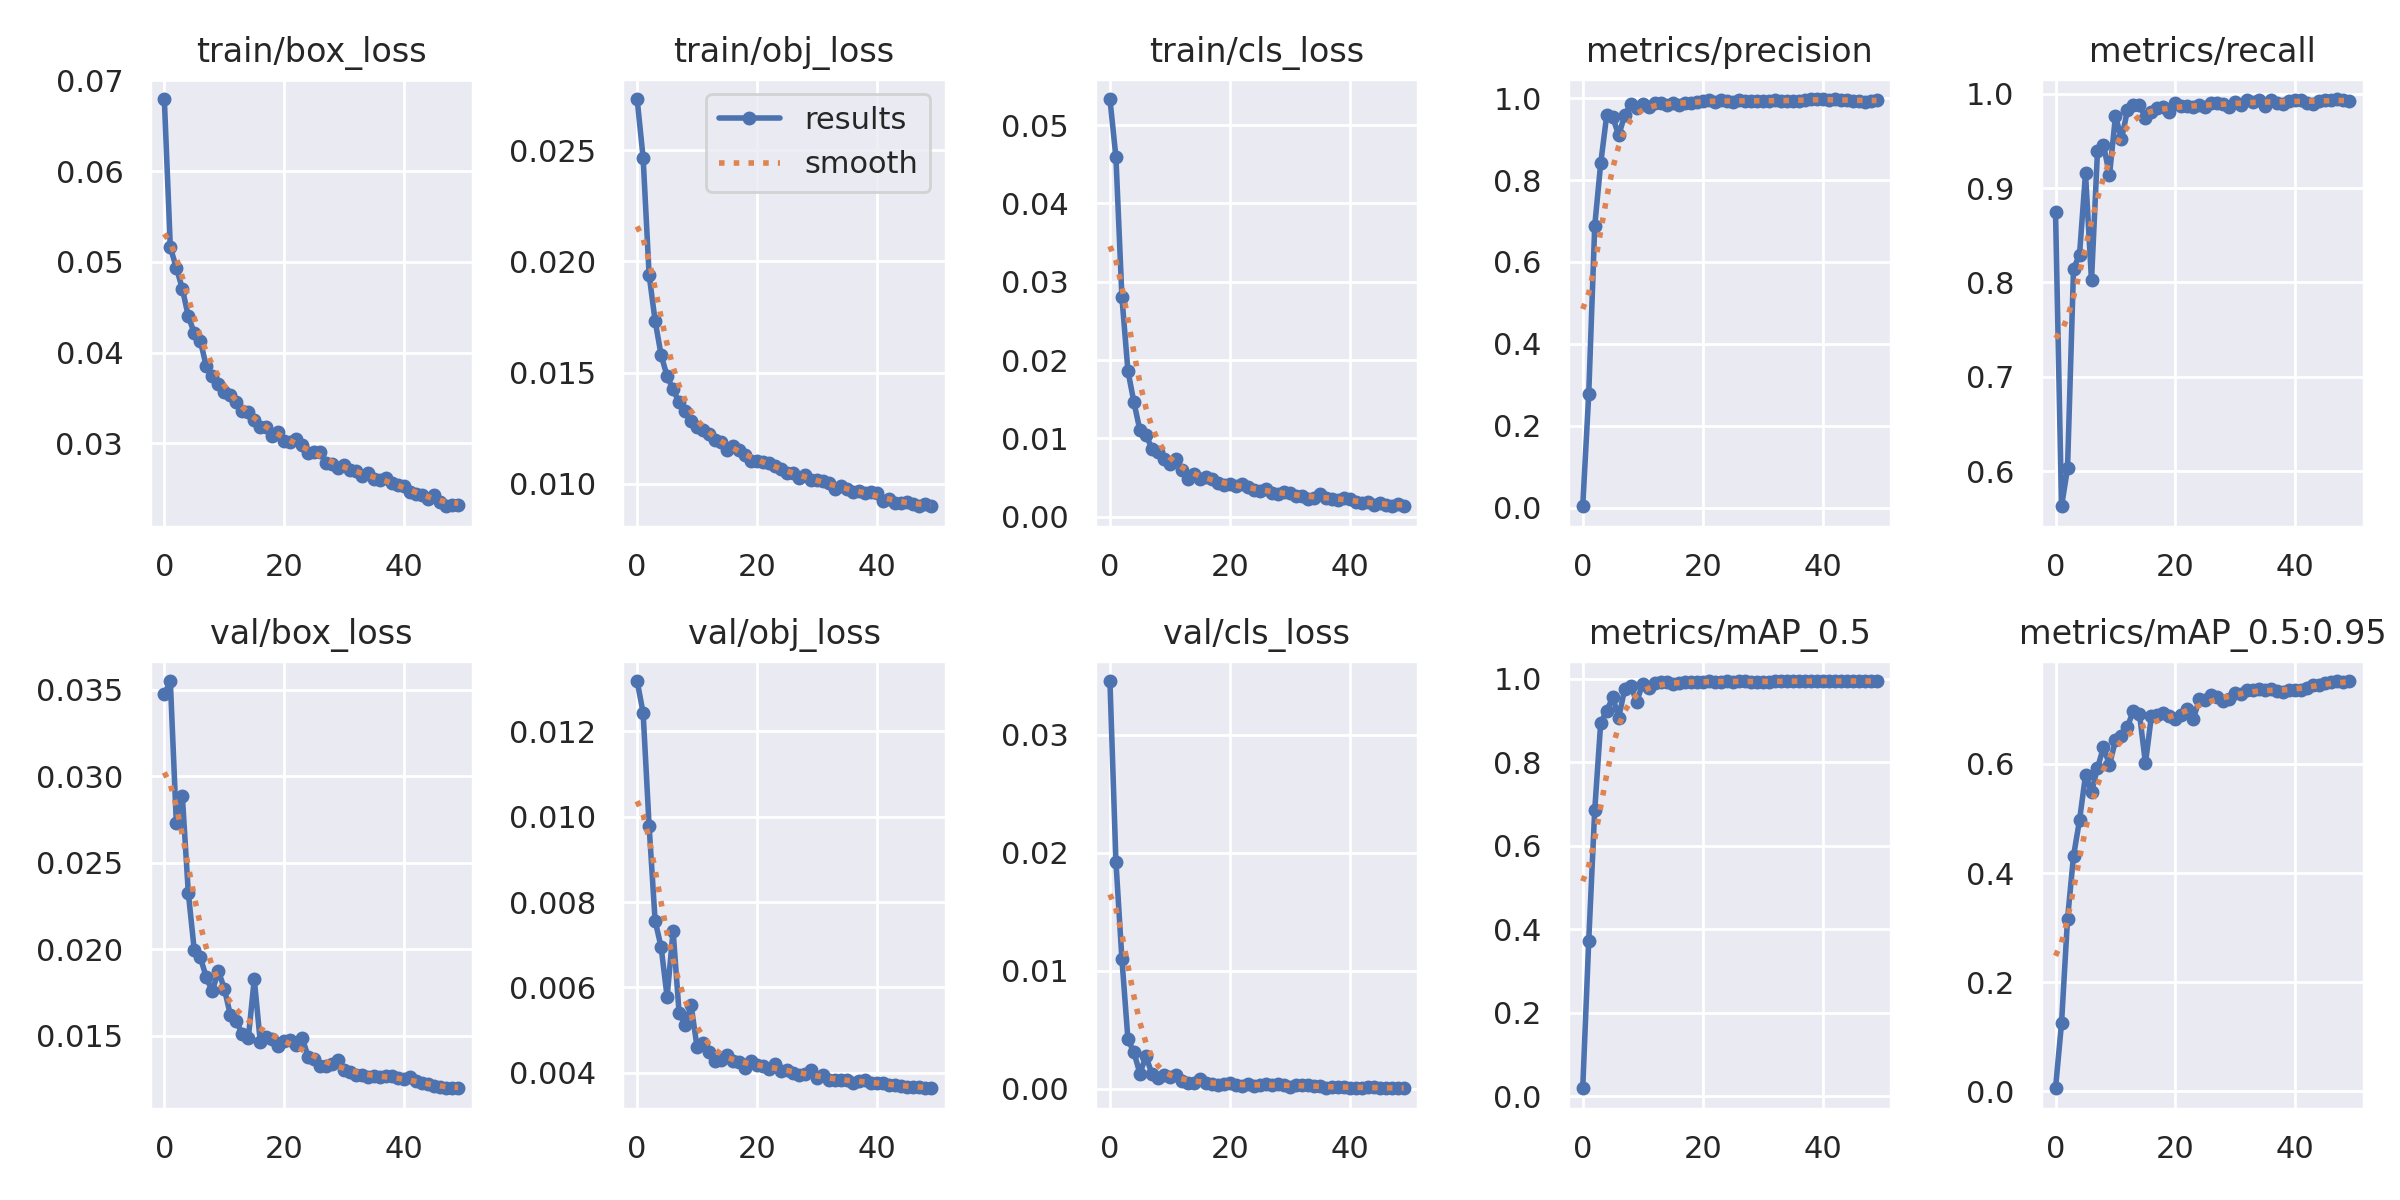

In [18]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason...
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/kaggle/working/yolov5/runs/train/yolov5s_results_1/results.png', width=1000)  # view results.png

# Curious? Visualize Our Training Data with Labels
After training starts, view train*.jpg images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in YOLOv5.

GROUND TRUTH TRAINING DATA:


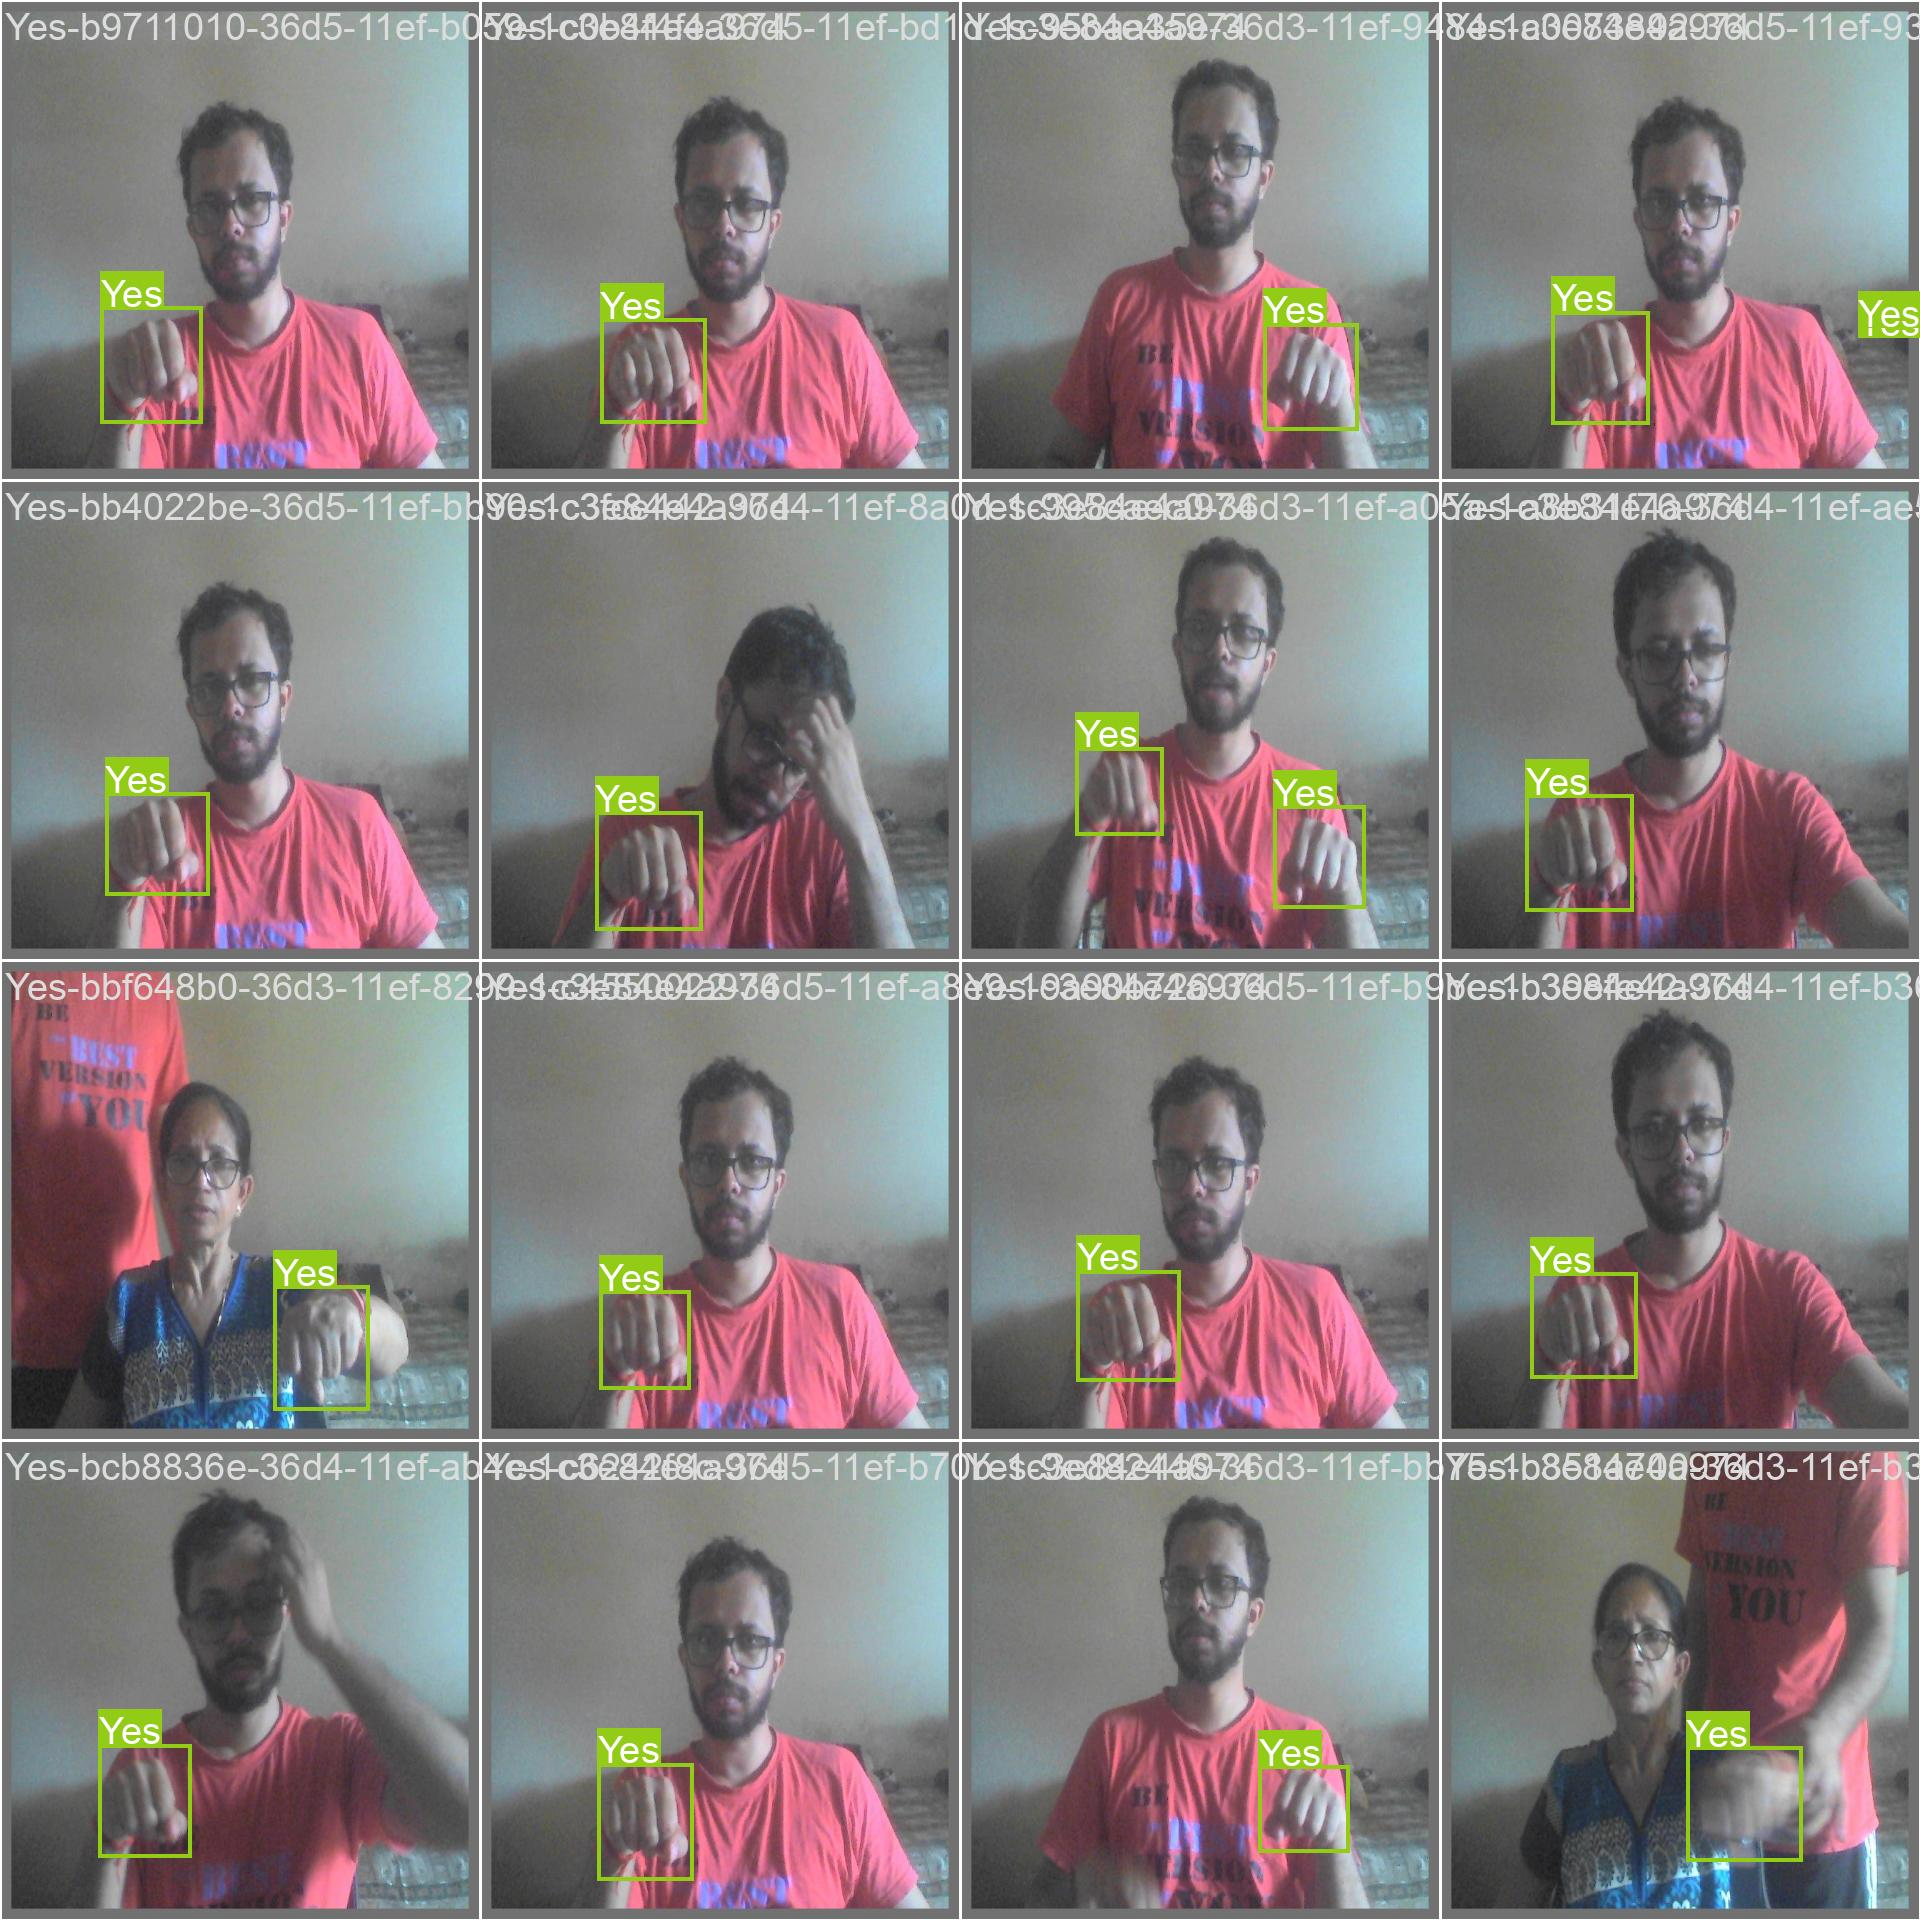

In [19]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/kaggle/working/yolov5/runs/train/yolov5s_results_1/val_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


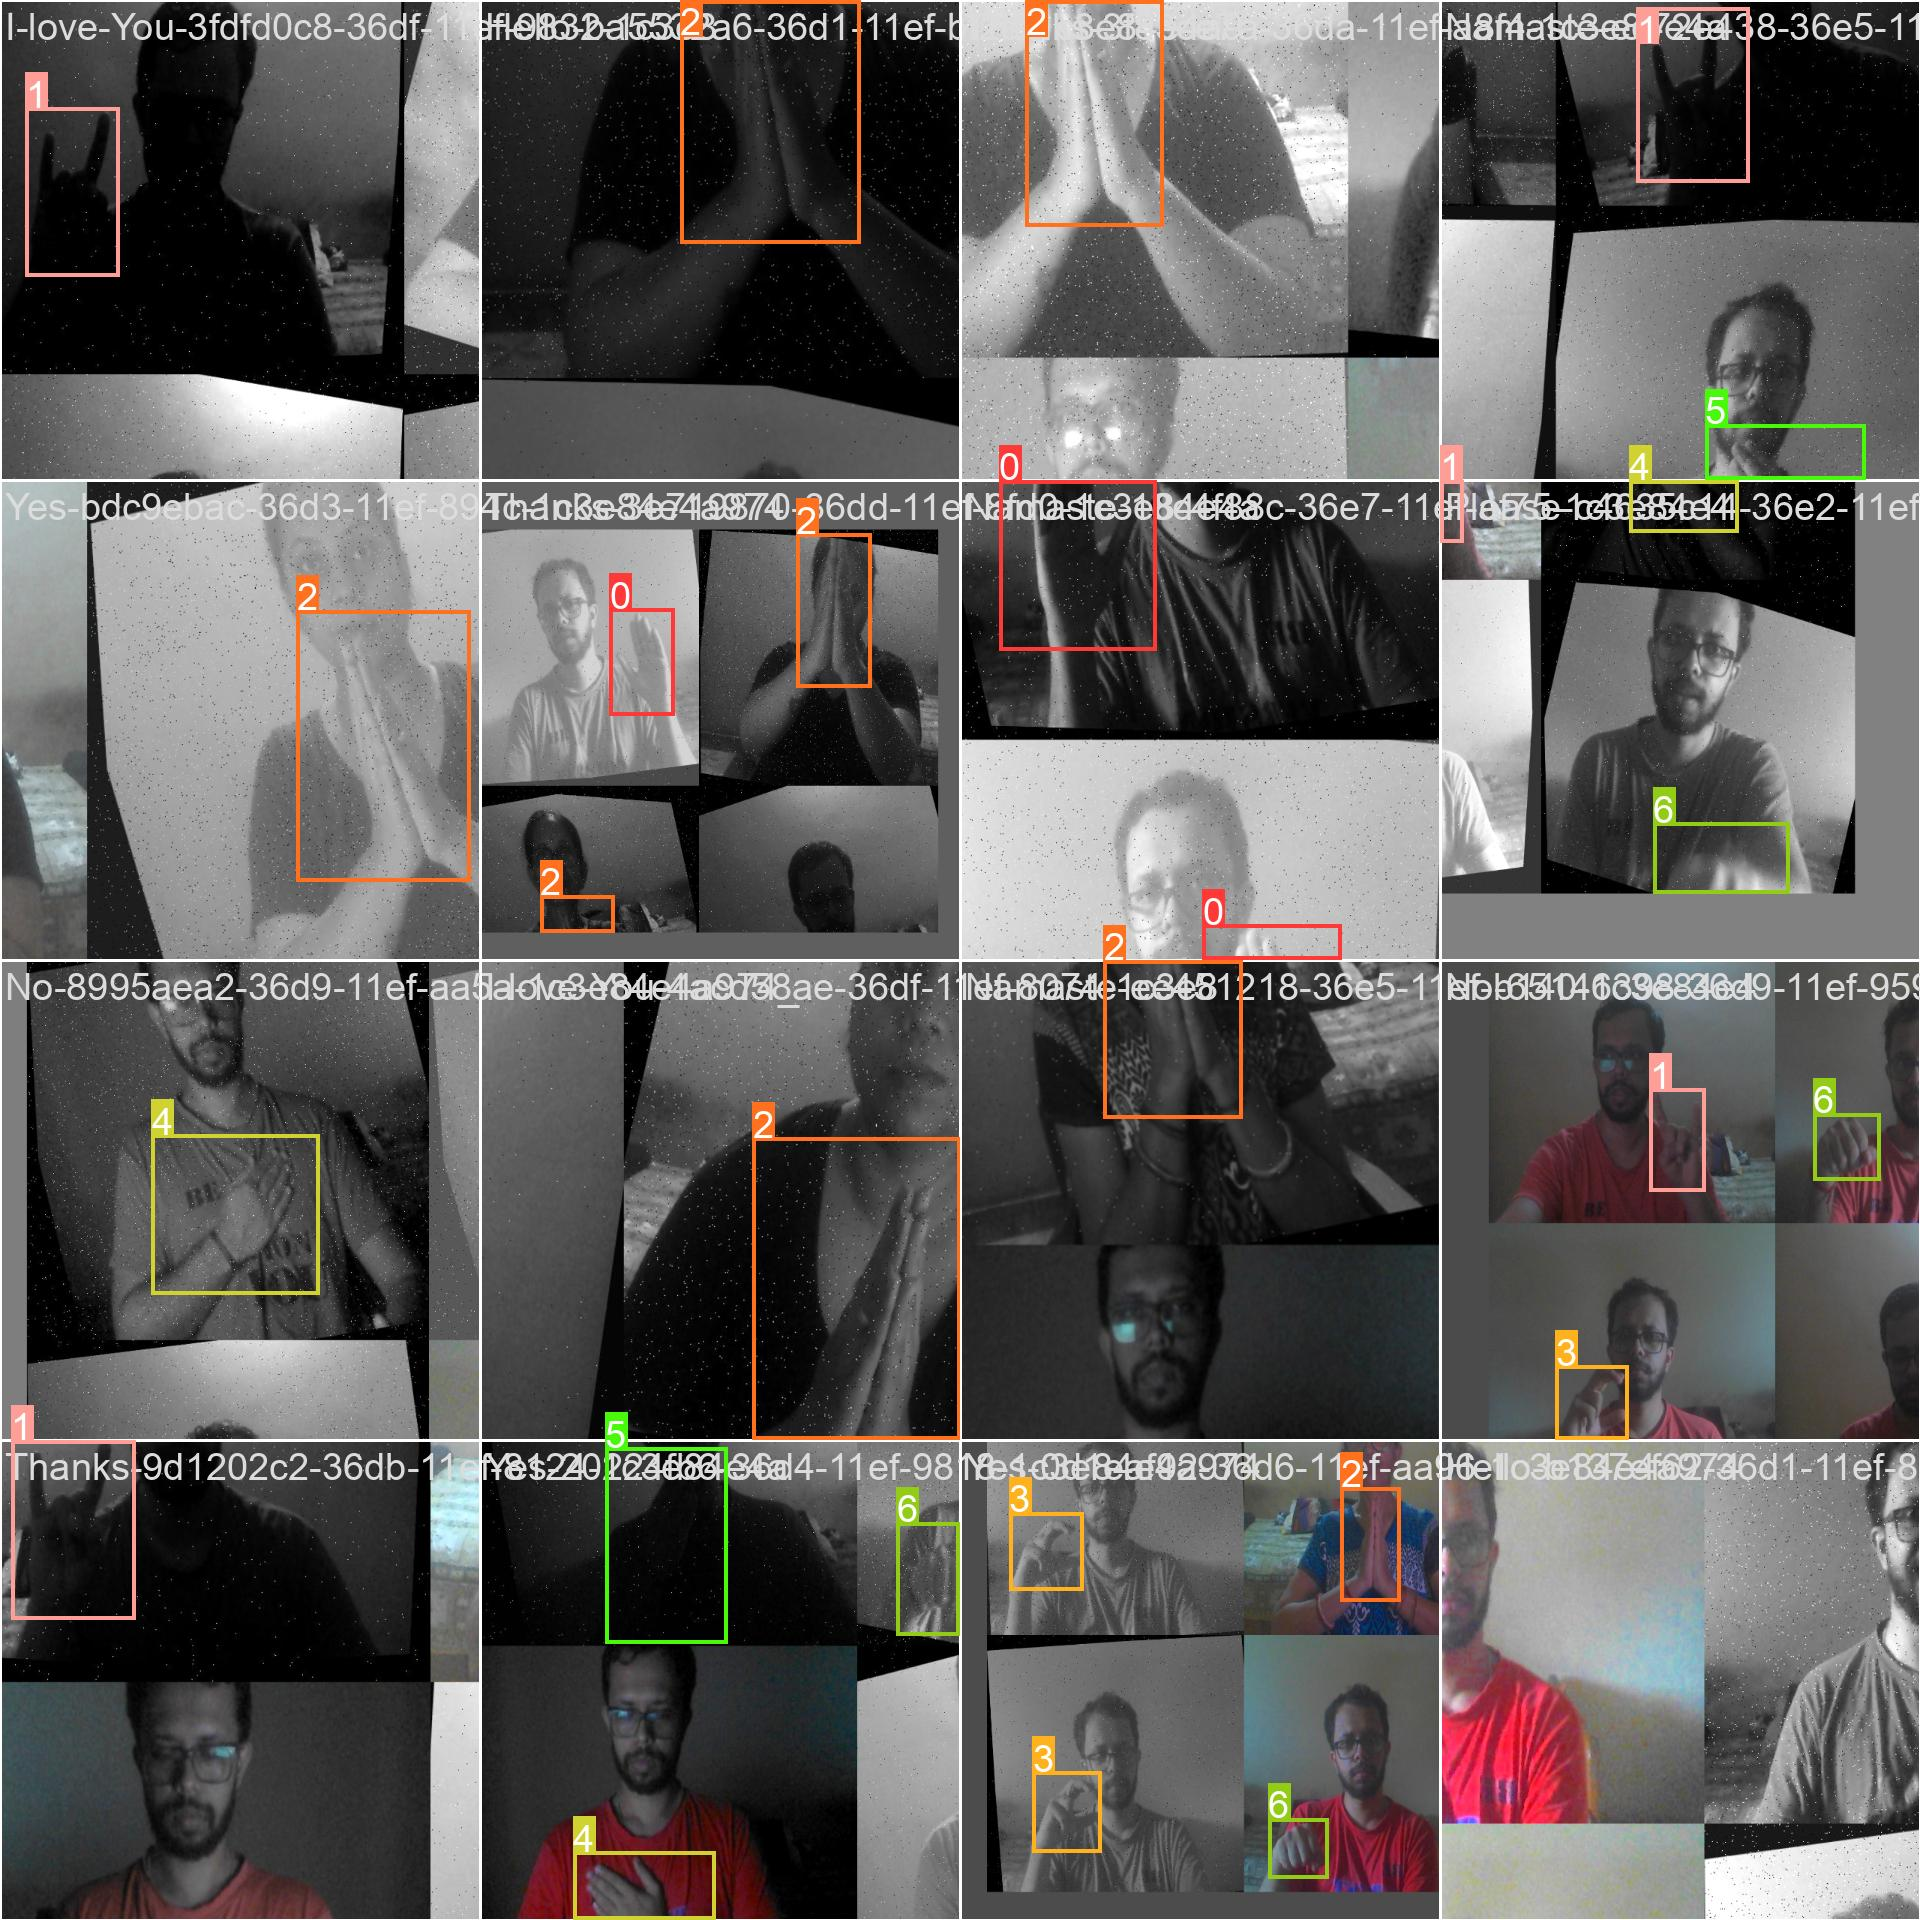

In [20]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/kaggle/working/yolov5/runs/train/yolov5s_results_1/train_batch0.jpg', width=900)

# Run Inference With Trained Weights
Run inference with a pretrained checkpoint on contents of test/images folder downloaded from Roboflow.

In [21]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [23]:
%ls runs/train/yolov5s_results_1/weights

best.pt  last.pt


In [24]:
!pwd

/kaggle/working/yolov5


In [25]:
#To find the best weights
%cd /kaggle/working/yolov5
!python detect.py --weights runs/train/yolov5s_results_1/weights/best.pt --img 640 --conf 0.5 --source '/kaggle/input/sign-language/test/images'

/kaggle/working/yolov5
detect: weights=['runs/train/yolov5s_results_1/weights/best.pt'], source=/kaggle/input/sign-language/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-334-g100a423b Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7262700 parameters, 0 gradients
image 1/349 /kaggle/input/sign-language/test/images/Hello-01375838-36d0-11ef-8075-1c3e84e4a974_jpg.rf.c38f0fb61c1b768dbdd7cae386730f63.jpg: 640x640 1 Hello, 6.8ms
image 2/349 /kaggle/input/sign-language/test/images/Hello-06cf4122-36d2-11ef-94eb-1c3e84e4a974_jpg.rf.9554f0

Listing files in directory:
['/kaggle/working/yolov5/runs/detect/exp']
Displaying image: /kaggle/working/yolov5/runs/detect/exp/Yes-25971240-36d4-11ef-b050-1c3e84e4a974_jpg.rf.e996a3084f8586db0746c09f37a011d3.jpg


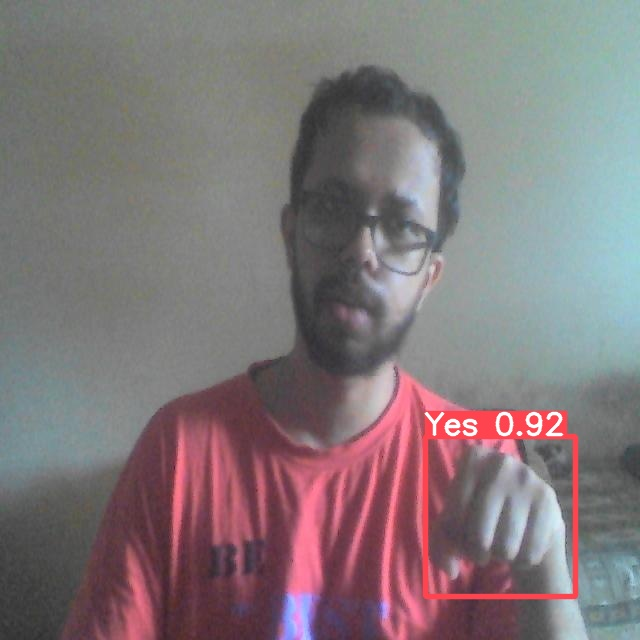



Displaying image: /kaggle/working/yolov5/runs/detect/exp/No-f91b6228-36d6-11ef-9946-1c3e84e4a974_jpg.rf.8b9d77adc207e05b9e5f29e7dcdfb07e.jpg


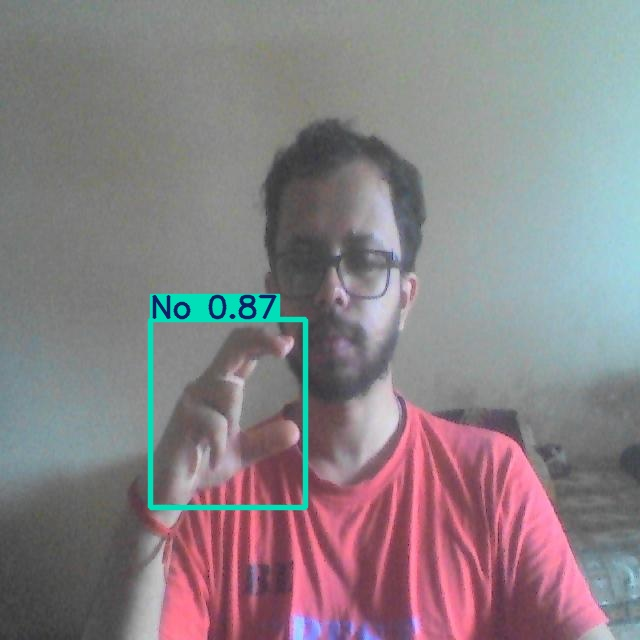



Displaying image: /kaggle/working/yolov5/runs/detect/exp/Yes-4f3d02d0-36d3-11ef-8831-1c3e84e4a974_jpg.rf.7caf4555991df6bf07415a25c79a61c3.jpg


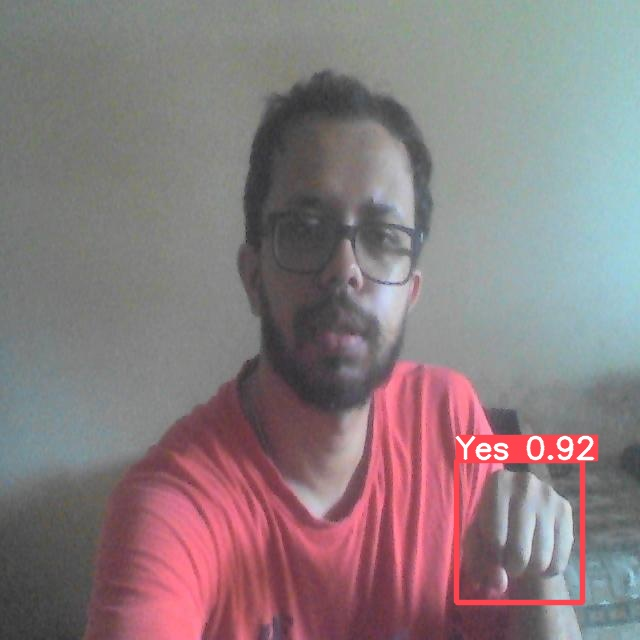



Displaying image: /kaggle/working/yolov5/runs/detect/exp/Thanks-fb0a5a86-36da-11ef-8d90-1c3e84e4a974_jpg.rf.30def7d6f9e8c1c2b800da685bc03061.jpg


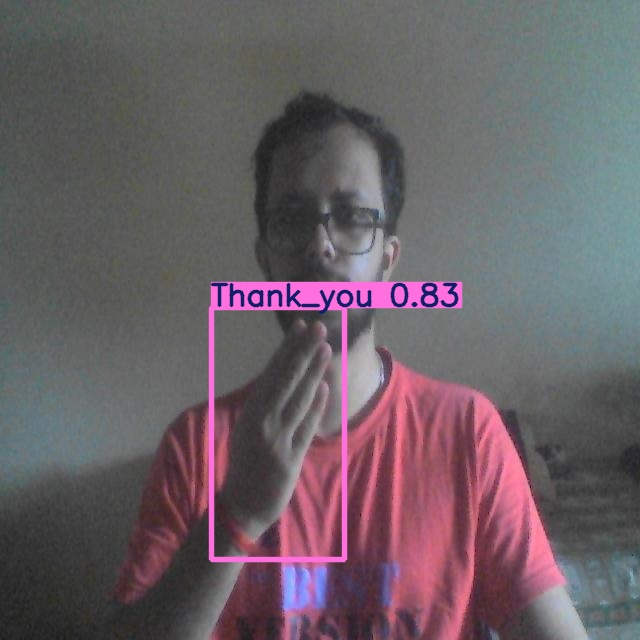



Displaying image: /kaggle/working/yolov5/runs/detect/exp/Namaste-c9dbf922-36e5-11ef-92cf-1c3e84e4a974_jpg.rf.a158ea08b7f82306b6713e3669fbb28e.jpg


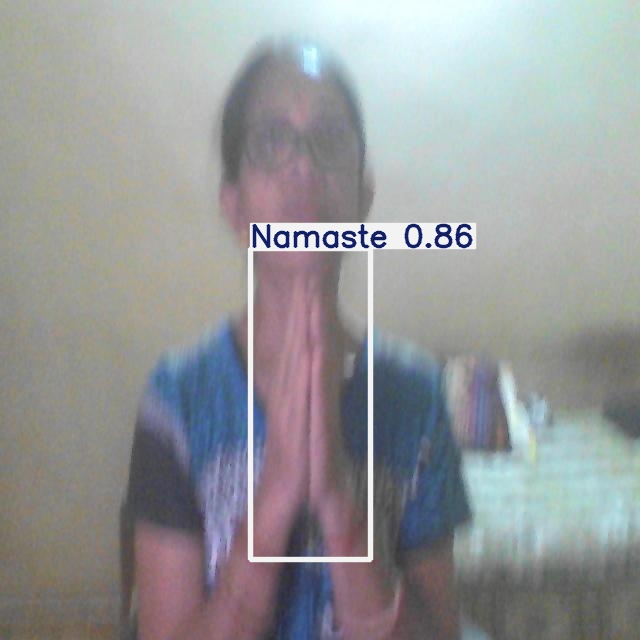



Displaying image: /kaggle/working/yolov5/runs/detect/exp/I-love-You-d80cb6dc-36de-11ef-9eb9-1c3e84e4a974_jpg.rf.0bf51c23ef1e22e20fc0a1404f3b0132.jpg


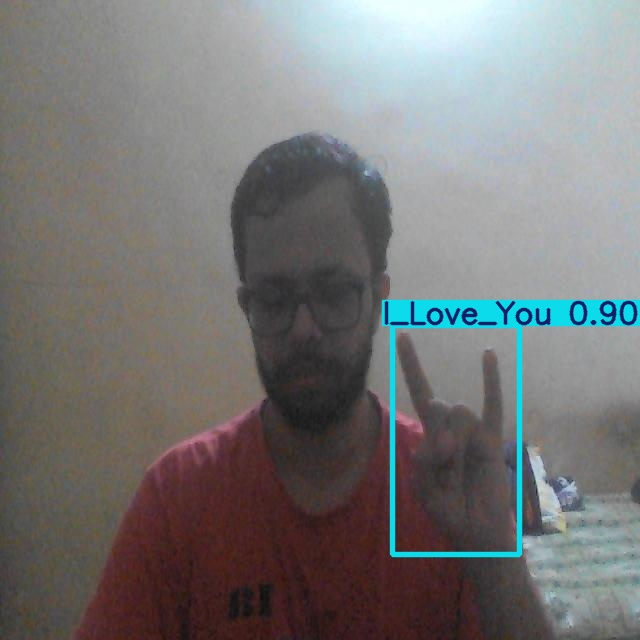

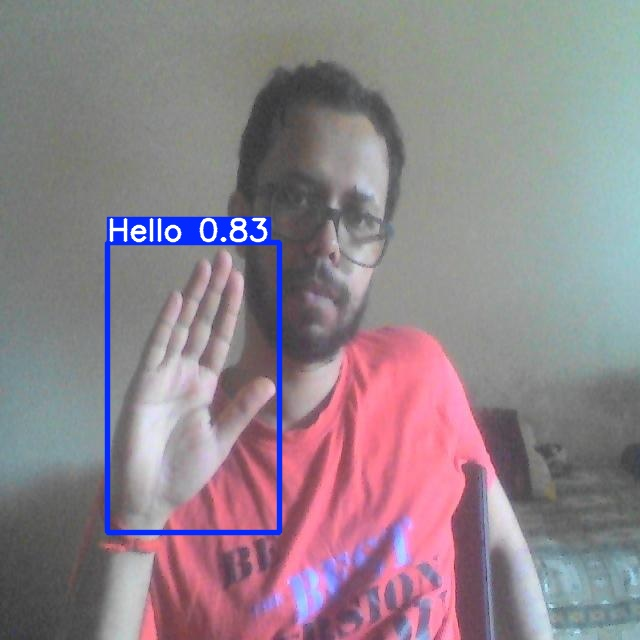



Displaying image: /kaggle/working/yolov5/runs/detect/exp/I-love-You-de67387e-36e0-11ef-a8e8-1c3e84e4a974_jpg.rf.ea400883329351be4ed807f476dc158b.jpg


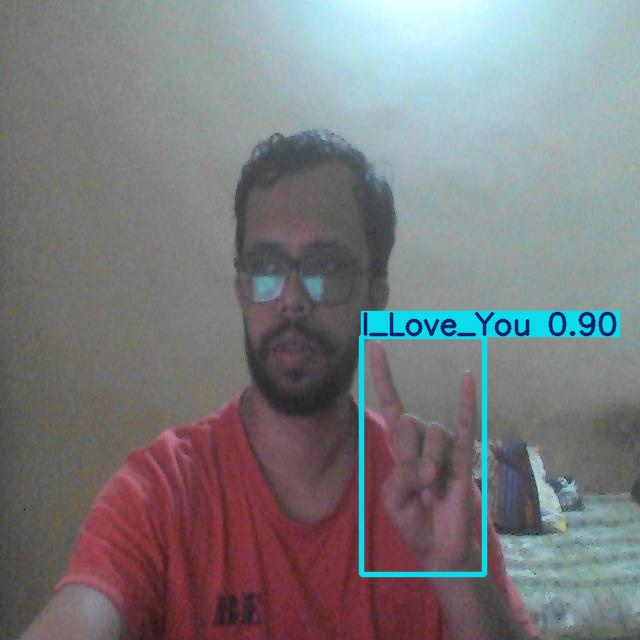



Displaying image: /kaggle/working/yolov5/runs/detect/exp/Yes-9c6162b4-36d5-11ef-bd80-1c3e84e4a974_jpg.rf.62e4dcdc8bae7db6206dc3528d5e1f7b.jpg


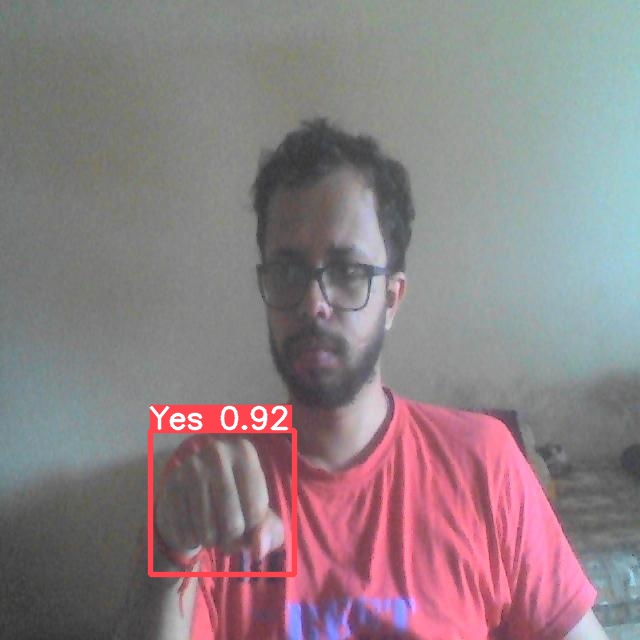



Displaying image: /kaggle/working/yolov5/runs/detect/exp/Thanks-489a4a0c-36da-11ef-8799-1c3e84e4a974_jpg.rf.eadeb0c284914b4d8f088fef03234343.jpg


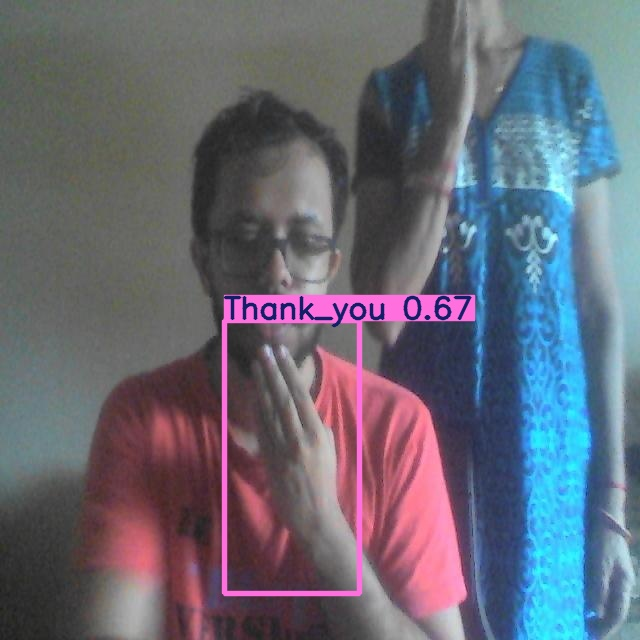



Displaying image: /kaggle/working/yolov5/runs/detect/exp/Hello-4a0b8e30-36d0-11ef-9421-1c3e84e4a974_jpg.rf.9bd3f5a3af6e6dce9afdfc48d2cc3042.jpg


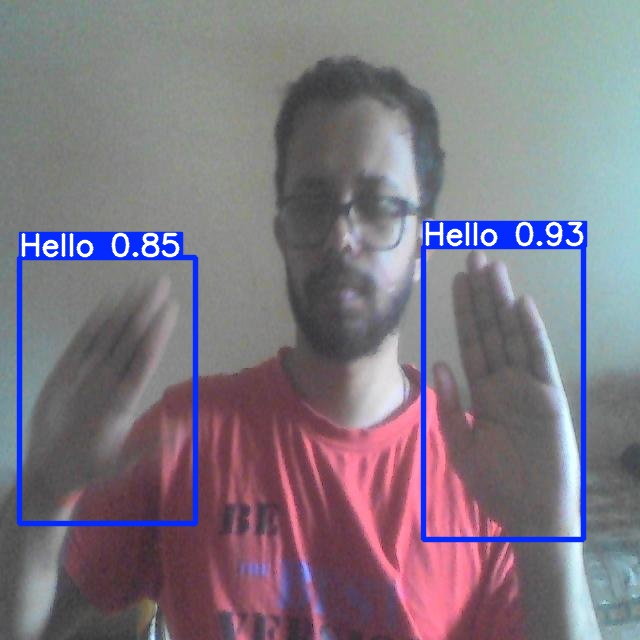



Displaying image: /kaggle/working/yolov5/runs/detect/exp/No-d6b50242-36d7-11ef-bd41-1c3e84e4a974_jpg.rf.93bc295f529183f9904e80d8231cede1.jpg


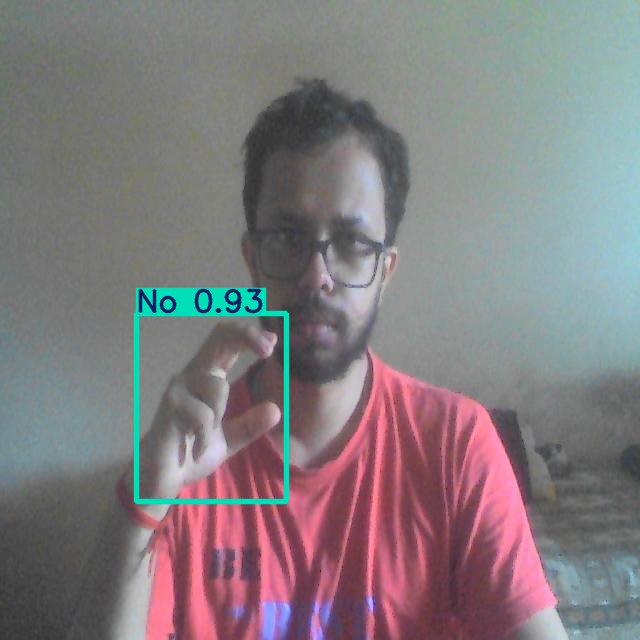



Displaying image: /kaggle/working/yolov5/runs/detect/exp/Yes-48c7ae58-36d5-11ef-bc1d-1c3e84e4a974_jpg.rf.eee08fdc5fa8a67578137ea023c70e33.jpg


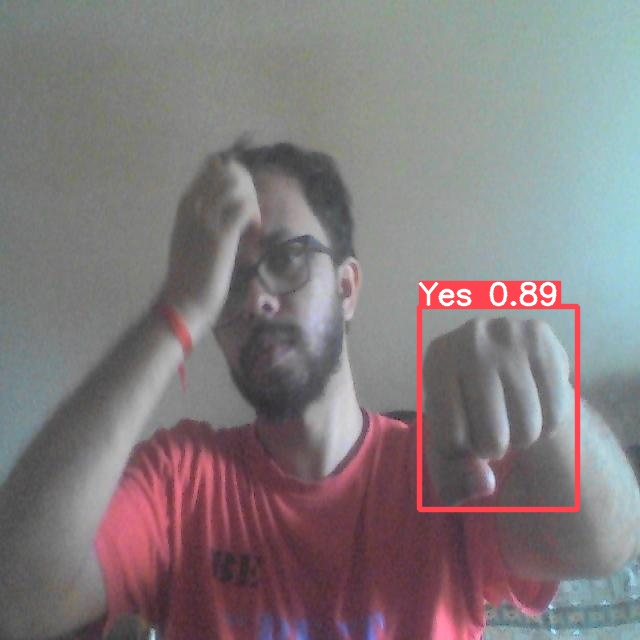



Displaying image: /kaggle/working/yolov5/runs/detect/exp/Hello-7ef09292-36d0-11ef-a3e9-1c3e84e4a974_jpg.rf.cd8c76a9c4745cdddbb5022aa48d9e10.jpg


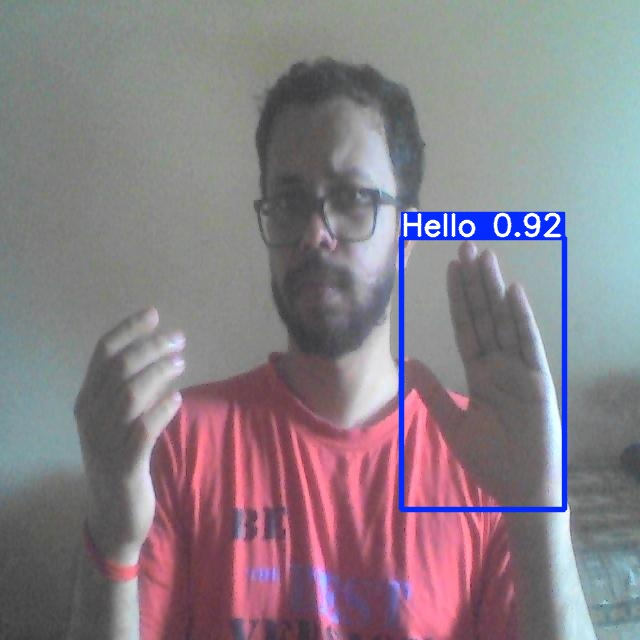



Displaying image: /kaggle/working/yolov5/runs/detect/exp/I-love-You-d4669dd8-36de-11ef-9e2d-1c3e84e4a974_jpg.rf.52f1de6fd36b85971a0caaae366f52a9.jpg


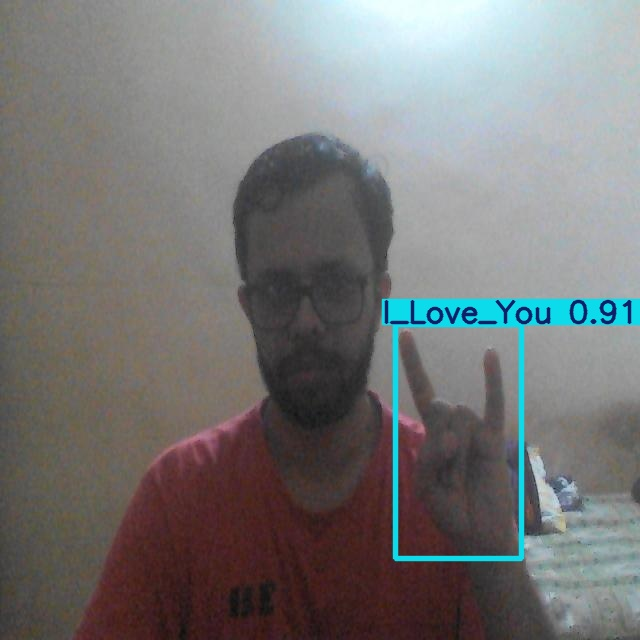



Displaying image: /kaggle/working/yolov5/runs/detect/exp/Thanks-72300d86-36dc-11ef-b3c1-1c3e84e4a974_jpg.rf.1efab7ef97fd5a5c5f2bbc3a70878f1e.jpg


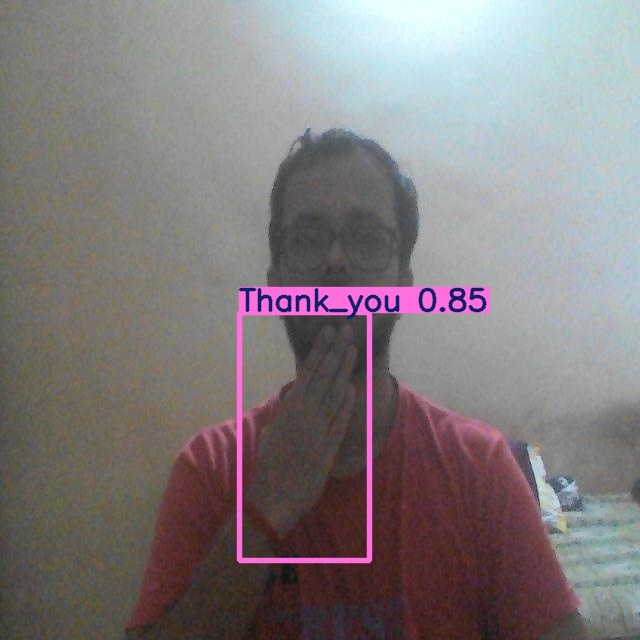

In [ ]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

# Check contents of the directory to ensure files are visible
print("Listing files in directory:")
print(glob.glob('/kaggle/working/yolov5/runs/detect/*'))

# Attempt to display images
image_paths = glob.glob('/kaggle/working/yolov5/runs/detect/exp/*.jpg')

if not image_paths:
    print("No images found in the specified path.")
else:
    for imageName in image_paths:
        print(f"Displaying image: {imageName}")
        display(Image(filename=imageName))
        print("\n")

# Download the directory for the future reference

In [59]:
# Change directory to the working directory
%cd /kaggle/working/

# Zip the kaggle directory and its contents
!zip -r Kaggle_working_Sign_language.zip *

# List the files to ensure the zip was created
!ls -lh Kaggle_working_Sign_language.zip


/kaggle/working
  adding: data.yaml (deflated 32%)
  adding: yolov5/ (stored 0%)
  adding: yolov5/requirements.txt (deflated 56%)
  adding: yolov5/benchmarks.py (deflated 68%)
  adding: yolov5/runs/ (stored 0%)
  adding: yolov5/runs/detect/ (stored 0%)
  adding: yolov5/runs/detect/exp/ (stored 0%)
  adding: yolov5/runs/detect/exp/Yes-25971240-36d4-11ef-b050-1c3e84e4a974_jpg.rf.e996a3084f8586db0746c09f37a011d3.jpg (deflated 5%)
  adding: yolov5/runs/detect/exp/No-f91b6228-36d6-11ef-9946-1c3e84e4a974_jpg.rf.8b9d77adc207e05b9e5f29e7dcdfb07e.jpg (deflated 5%)
  adding: yolov5/runs/detect/exp/Yes-4f3d02d0-36d3-11ef-8831-1c3e84e4a974_jpg.rf.7caf4555991df6bf07415a25c79a61c3.jpg (deflated 5%)
  adding: yolov5/runs/detect/exp/Thanks-fb0a5a86-36da-11ef-8d90-1c3e84e4a974_jpg.rf.30def7d6f9e8c1c2b800da685bc03061.jpg (deflated 4%)
  adding: yolov5/runs/detect/exp/Namaste-c9dbf922-36e5-11ef-92cf-1c3e84e4a974_jpg.rf.a158ea08b7f82306b6713e3669fbb28e.jpg (deflated 5%)
  adding: yolov5/runs/detect/exp/I-